In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from sklearn.preprocessing import StandardScaler

import torch
import torch_geometric
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# import src.loading as loading
import src.processing as processing

from src.visualization.analyse_model import plot_errors_labels_comparison

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


In [4]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

Processing...
Done!


## Classic GCN Planetoid

In [5]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [6]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
history = {"loss":[], "accuracy":[]}
for epoch in range(600):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
    history["loss"].append(loss.detach().cpu().numpy())
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    history["accuracy"].append(acc)

model.eval()
print(f'Accuracy: {history["accuracy"][-1]:.4f}')   

Accuracy: 0.7860


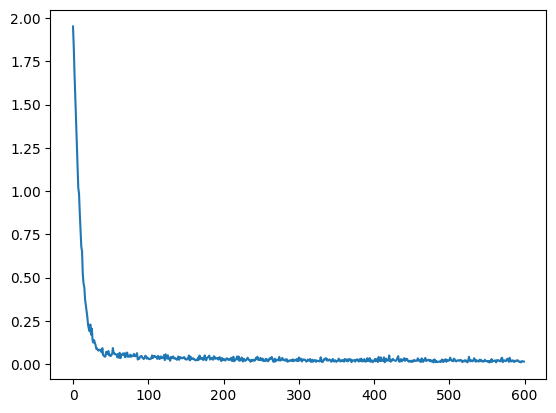

In [7]:
plt.plot(history["loss"])

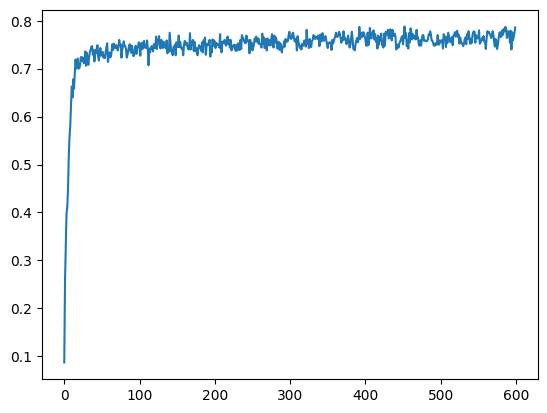

In [8]:
plt.plot(history["accuracy"])

## Personal GAT

In [ ]:
from src.models.nn_layers import MLPModel
from src.models.gnn_layers import MyGATConv
from src.models.ML_frameworks import GNNFramework

class myGATNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = MyGATConv(
            in_channels=(dataset.num_node_features,dataset.num_node_features), 
            out_channels=16,
            negative_slope=0,
            add_self_loops=True,
            edge_dim=None,
            src_content_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            src_edge_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            dst_content_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            dst_edge_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool)
        )
        self.conv2 = MyGATConv(
            in_channels=(16,16), 
            out_channels=dataset.num_classes,
            negative_slope=0,
            add_self_loops=True,
            edge_dim=None,
            src_content_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            src_edge_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            dst_content_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            dst_edge_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool)
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = myGATNetwork().to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
history = {"loss":[], "accuracy":[]}
for epoch in range(600):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    history["loss"].append(loss.detach().cpu().numpy())
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    history["accuracy"].append(acc)

model.eval()
print(f'Accuracy: {history["accuracy"][-1]:.4f}')   

Accuracy: 0.6310


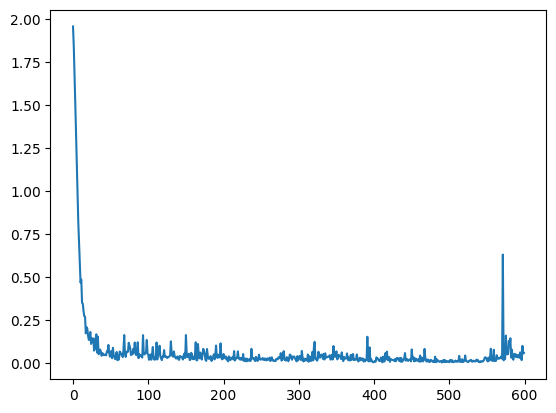

In [11]:
plt.plot(history["loss"])

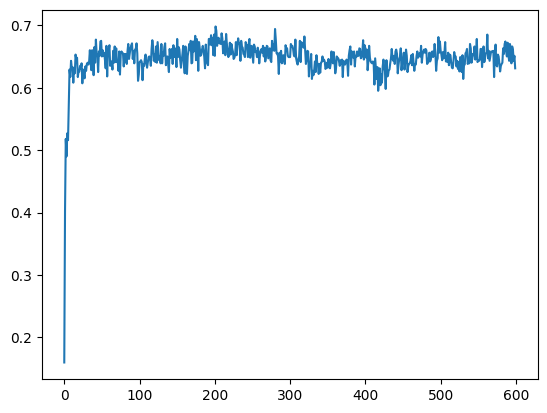

In [12]:
plt.plot(history["accuracy"])

## Personal Bayesian GAT

In [13]:
from src.models.gnn_layers import MyBGATConv

class myBGATNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = MyBGATConv(
            in_channels=(dataset.num_node_features,dataset.num_node_features), 
            out_channels=16,
            n_latent=20,
            negative_slope=0,
            add_self_loops=True,
            edge_dim=None,
            src_content_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            src_edge_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            dst_content_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            dst_edge_mask=torch.Tensor([True for _ in range(dataset.num_node_features)]).to(torch.bool),
            device=device
        )
        self.conv2 = MyBGATConv(
            in_channels=(16,16), 
            out_channels=dataset.num_classes,
            n_latent=20,
            negative_slope=0,
            add_self_loops=True,
            edge_dim=None,
            src_content_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            src_edge_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            dst_content_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            dst_edge_mask=torch.Tensor([True for _ in range(16)]).to(torch.bool),
            device=device
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

model = myBGATNetwork().to(device)

In [14]:
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
history = {"loss":[],"accuracy":[]}
for epoch in range(2400):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss += model.conv1.eval_all_losses()
    loss += model.conv2.eval_all_losses()
    loss.backward()
    optimizer.step()

    history["loss"].append(loss.detach().cpu().numpy())
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    history["accuracy"].append(acc)

model.eval()
print(f'Accuracy: {history["accuracy"][-1]:.4f}')

Accuracy: 0.6440


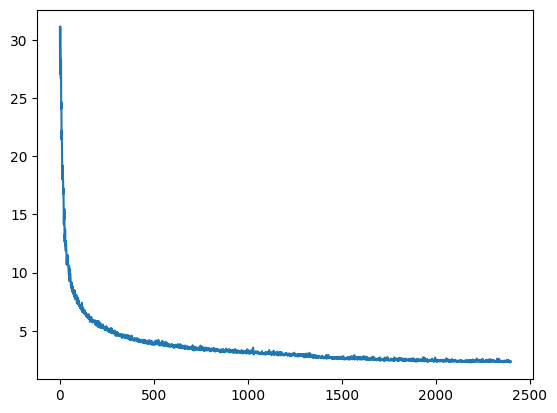

In [15]:
plt.plot(history["loss"])

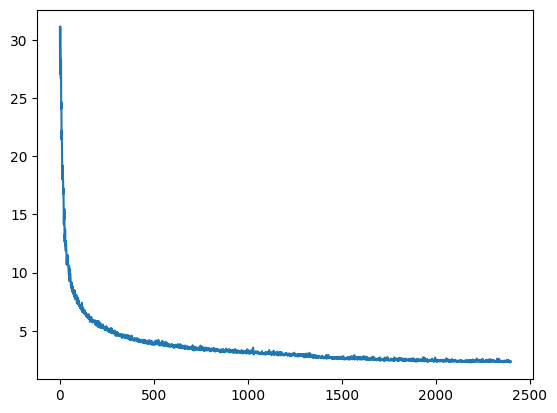

In [16]:
plt.plot(history["loss"])

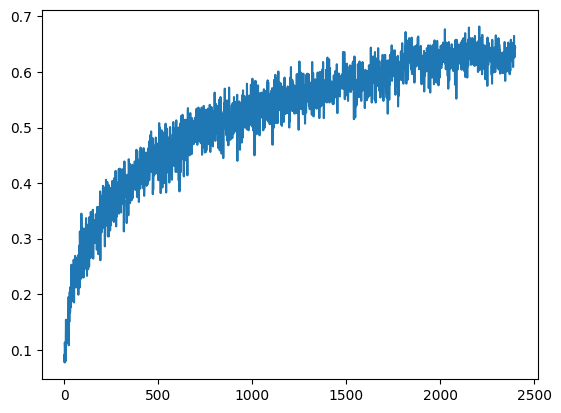

In [17]:
plt.plot(history["accuracy"])

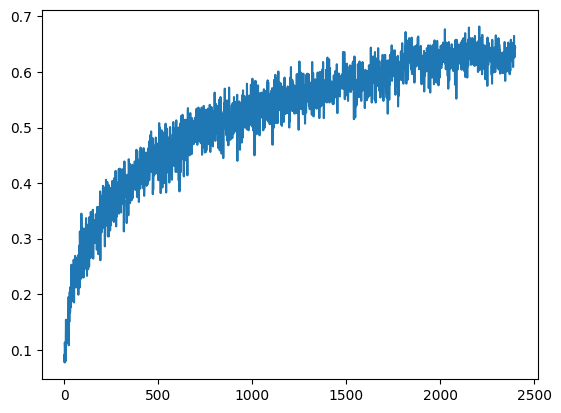

In [18]:
plt.plot(history["accuracy"])